# Dependencies

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC, NuSVC
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
seed(0)

%matplotlib inline
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

# Load data

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

print('Train set shape:', train.shape)
print('Test set shape:', test.shape)
print('Train set overview:')
display(train.head())

Train set shape: (262144, 258)
Test set shape: (131073, 257)
Train set overview:


,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
0,707b395ecdcbb4dc2eabea00e4d1b179,-2.070654,1.018160,0.228643,0.857221,0.052271,0.230303,-6.385090,0.439369,-0.721946,-0.227027,0.575964,1.541908,1.745286,-0.624271,3.600958,1.176489,-0.182776,-0.228391,1.682263,-0.833236,-4.377688,-5.372410,-0.477742,-0.179005,-0.516475,0.127391,-0.857591,-0.461500,2.160303,-2.118371,0.515493,-1.201493,-0.027377,-1.154024,0.753204,-0.179651,-0.807341,-1.663626,0.893806,...,-1.829848,2.347131,0.082462,-1.012654,0.593752,2.904654,-0.428974,-0.919979,2.849575,-0.906744,0.729459,0.386140,0.319814,-0.407682,-0.170667,-1.242919,-1.719046,-0.132395,-0.368991,-5.112553,-2.085988,-0.897257,1.080671,-0.273262,0.342824,0.640177,-0.415298,-0.483126,-0.080799,2.416224,0.351895,0.618824,-1.542423,0.598175,0.611757,0.678772,0.247059,-0.806677,-0.193649,0
1,5880c03c6582a7b42248668e56b4bdec,-0.491702,0.082645,-0.011193,1.071266,-0.346347,-0.082209,0.110579,-0.382374,-0.229620,0.783980,-1.280579,-1.003480,-7.753201,-1.320547,0.919078,-1.036068,0.030213,0.910172,-0.905345,0.646641,-0.465291,-0.531735,-0.756781,0.193724,0.224277,-0.474412,1.885805,0.205439,-6.481422,1.035620,-0.453623,0.375936,-0.320670,-0.144646,-0.220129,0.577826,-0.360512,-0.600107,0.008111,...,0.982205,-1.161978,0.532269,1.133215,0.003503,-1.390962,0.158572,0.143794,-0.317185,1.017192,-0.395342,-0.642357,-0.627209,0.257271,-1.461564,0.325613,1.628369,0.640040,0.750735,1.164573,0.900373,0.063489,0.948158,0.273014,-1.269147,-0.251101,-2.271731,-0.044167,-0.443766,-1.144794,-0.645115,-1.246090,2.613357,-0.479664,1.581289,0.931258,0.151937,-0.766595,0.474351,0
2,4ccbcb3d13e5072ff1d9c61afe2c4f77,-1.680473,0.860529,-1.076195,0.740124,3.678445,0.28855

# Model

## Model parameters

In [3]:
N_FOLDS = 5

### You can find evaluation metrics for each model on each fold below on this cell output log. (It's hidden to keep the code clean)

In [4]:
# INITIALIZE VARIABLES
cols = [c for c in train.columns if c not in ['id', 'target', 'wheezy-copper-turtle-magic', 'preds']]
test['target_pca_stdv'] = 0
train['preds_pca_stdv'] = 0
test['target_pca'] = 0
train['preds_pca'] = 0
test['target_pca_vt'] = 0
train['preds_pca_vt'] = 0
test['target_pca_vt_stdv'] = 0
train['preds_pca_vt_stdv'] = 0


# BUILD 512 MODELS
for i in range(512):
    print('wheezy-copper-turtle-magic {}\n'.format(i))

    # EXTRACT SUBSET OF DATASET WHERE WHEEZY-MAGIC EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index
    idx2 = test2.index
    train2.reset_index(drop=True, inplace=True)

    data = pd.concat([pd.DataFrame(train2[cols]), pd.DataFrame(test2[cols])])
    data2 = StandardScaler().fit_transform(PCA(svd_solver='full', n_components='mle').fit_transform(data[cols]))
    train3 = data2[:train2.shape[0]]
    test3 = data2[train2.shape[0]:]
#     sel = VarianceThreshold(threshold=2).fit(train2[cols])
#     train3 = sel.transform(train2[cols])
#     test3 = sel.transform(test2[cols])
#     scaler = StandardScaler().fit(train3)
#     train3 = scaler.transform(train3)
#     test3 = scaler.transform(test3)

    skf = StratifiedKFold(n_splits=N_FOLDS, random_state=0)
    counter = 0

    for train_index, val_index in skf.split(train3, train2['target']):
        counter += 1
        print('Fold {}\n'.format(counter))

        model = QuadraticDiscriminantAnalysis()
        model.fit(train3[train_index,:], train2.loc[train_index]['target'])

        train_predictions = model.predict(train3[train_index,:])
        val_predictions = model.predict(train3[val_index,:])

        train_auc = roc_auc_score(train2.loc[train_index]['target'], train_predictions) * 100
        val_auc = roc_auc_score(train2.loc[val_index]['target'], val_predictions) * 100
        train_precision = precision_score(train2.loc[train_index]['target'], train_predictions) * 100
        val_precision = precision_score(train2.loc[val_index]['target'], val_predictions) * 100
        train_recall = recall_score(train2.loc[train_index]['target'], train_predictions) * 100
        val_recall = recall_score(train2.loc[val_index]['target'], val_predictions) * 100
        print('-----Train----------')
        print('AUC: %.2f Precision: %.2f Recall: %.2f \n' % (train_auc, train_precision, train_recall))
        print('-----Validation-----')
        print('AUC: %.2f Precision: %.2f Recall: %.2f \n' % (val_auc, val_precision, val_recall))

        # Make predictions
        train['preds_pca_stdv'].loc[idx1] += model.predict_proba(train3)[:,1] / N_FOLDS
        test['target_pca_stdv'].loc[idx2] += model.predict_proba(test3)[:,1] / N_FOLDS

wheezy-copper-turtle-magic 0

Fold 1

-----Train----------
AUC: 97.65 Precision: 98.08 Recall: 97.14 

-----Validation-----
AUC: 88.85 Precision: 90.20 Recall: 86.79 

Fold 2

-----Train----------
AUC: 97.43 Precision: 96.71 Recall: 98.10 

-----Validation-----
AUC: 95.32 Precision: 96.15 Recall: 94.34 

Fold 3

-----Train----------
AUC: 96.97 Precision: 96.24 Recall: 97.62 

-----Validation-----
AUC: 98.11 Precision: 100.00 Recall: 96.23 

Fold 4

-----Train----------
AUC: 97.90 Precision: 97.64 Recall: 98.10 

-----Validation-----
AUC: 88.64 Precision: 90.00 Recall: 86.54 

Fold 5

-----Train----------
AUC: 97.43 Precision: 97.17 Recall: 97.63 

-----Validation-----
AUC: 92.38 Precision: 95.83 Recall: 88.46 

wheezy-copper-turtle-magic 1

Fold 1

-----Train----------
AUC: 96.61 Precision: 95.05 Recall: 97.96 

-----Validation-----
AUC: 93.17 Precision: 93.88 Recall: 92.00 

Fold 2

-----Train----------
AUC: 97.36 Precision: 95.59 Recall: 98.98 

-----Validation-----
AUC: 87.35 Precis

In [5]:
# BUILD 512 MODELS
for i in range(512):
    print('wheezy-copper-turtle-magic {}\n'.format(i))

    # EXTRACT SUBSET OF DATASET WHERE WHEEZY-MAGIC EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index
    idx2 = test2.index
    train2.reset_index(drop=True, inplace=True)

    data = pd.concat([pd.DataFrame(train2[cols]), pd.DataFrame(test2[cols])])
    data2 = PCA(svd_solver='full', n_components='mle').fit_transform(data[cols])
    train3 = data2[:train2.shape[0]]
    test3 = data2[train2.shape[0]:]

    skf = StratifiedKFold(n_splits=N_FOLDS, random_state=0)
    counter = 0

    for train_index, val_index in skf.split(train3, train2['target']):
        counter += 1
        print('Fold {}\n'.format(counter))

        model = QuadraticDiscriminantAnalysis()
        model.fit(train3[train_index,:], train2.loc[train_index]['target'])

        train_predictions = model.predict(train3[train_index,:])
        val_predictions = model.predict(train3[val_index,:])

        train_auc = roc_auc_score(train2.loc[train_index]['target'], train_predictions) * 100
        val_auc = roc_auc_score(train2.loc[val_index]['target'], val_predictions) * 100
        train_precision = precision_score(train2.loc[train_index]['target'], train_predictions) * 100
        val_precision = precision_score(train2.loc[val_index]['target'], val_predictions) * 100
        train_recall = recall_score(train2.loc[train_index]['target'], train_predictions) * 100
        val_recall = recall_score(train2.loc[val_index]['target'], val_predictions) * 100
        print('-----Train----------')
        print('AUC: %.2f Precision: %.2f Recall: %.2f \n' % (train_auc, train_precision, train_recall))
        print('-----Validation-----')
        print('AUC: %.2f Precision: %.2f Recall: %.2f \n' % (val_auc, val_precision, val_recall))

        # Make predictions
        train['preds_pca'].loc[idx1] += model.predict_proba(train3)[:,1] / N_FOLDS
        test['target_pca'].loc[idx2] += model.predict_proba(test3)[:,1] / N_FOLDS

wheezy-copper-turtle-magic 0

Fold 1

-----Train----------
AUC: 97.65 Precision: 98.08 Recall: 97.14 

-----Validation-----
AUC: 88.85 Precision: 90.20 Recall: 86.79 

Fold 2

-----Train----------
AUC: 97.43 Precision: 96.71 Recall: 98.10 

-----Validation-----
AUC: 95.32 Precision: 96.15 Recall: 94.34 

Fold 3

-----Train----------
AUC: 96.97 Precision: 96.24 Recall: 97.62 

-----Validation-----
AUC: 98.11 Precision: 100.00 Recall: 96.23 

Fold 4

-----Train----------
AUC: 97.90 Precision: 97.64 Recall: 98.10 

-----Validation-----
AUC: 88.64 Precision: 90.00 Recall: 86.54 

Fold 5

-----Train----------
AUC: 97.43 Precision: 97.17 Recall: 97.63 

-----Validation-----
AUC: 92.38 Precision: 95.83 Recall: 88.46 

wheezy-copper-turtle-magic 1

Fold 1

-----Train----------
AUC: 96.61 Precision: 95.05 Recall: 97.96 

-----Validation-----
AUC: 93.17 Precision: 93.88 Recall: 92.00 

Fold 2

-----Train----------
AUC: 97.36 Precision: 95.59 Recall: 98.98 

-----Validation-----
AUC: 87.35 Precis

In [6]:
# BUILD 512 MODELS
for i in range(512):
    print('wheezy-copper-turtle-magic {}\n'.format(i))

    # EXTRACT SUBSET OF DATASET WHERE WHEEZY-MAGIC EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index
    idx2 = test2.index
    train2.reset_index(drop=True, inplace=True)

    data = pd.concat([pd.DataFrame(train2[cols]), pd.DataFrame(test2[cols])])
    data2 = PCA(svd_solver='full', n_components='mle').fit_transform(data[cols])
    train3 = data2[:train2.shape[0]]
    test3 = data2[train2.shape[0]:]
    sel = VarianceThreshold(threshold=2).fit(train3)
    train3 = sel.transform(train3)
    test3 = sel.transform(test3)

    skf = StratifiedKFold(n_splits=N_FOLDS, random_state=0)
    counter = 0

    for train_index, val_index in skf.split(train3, train2['target']):
        counter += 1
        print('Fold {}\n'.format(counter))

        model = QuadraticDiscriminantAnalysis()
        model.fit(train3[train_index,:], train2.loc[train_index]['target'])

        train_predictions = model.predict(train3[train_index,:])
        val_predictions = model.predict(train3[val_index,:])

        train_auc = roc_auc_score(train2.loc[train_index]['target'], train_predictions) * 100
        val_auc = roc_auc_score(train2.loc[val_index]['target'], val_predictions) * 100
        train_precision = precision_score(train2.loc[train_index]['target'], train_predictions) * 100
        val_precision = precision_score(train2.loc[val_index]['target'], val_predictions) * 100
        train_recall = recall_score(train2.loc[train_index]['target'], train_predictions) * 100
        val_recall = recall_score(train2.loc[val_index]['target'], val_predictions) * 100
        print('-----Train----------')
        print('AUC: %.2f Precision: %.2f Recall: %.2f \n' % (train_auc, train_precision, train_recall))
        print('-----Validation-----')
        print('AUC: %.2f Precision: %.2f Recall: %.2f \n' % (val_auc, val_precision, val_recall))

        # Make predictions
        train['preds_pca_vt'].loc[idx1] += model.predict_proba(train3)[:,1] / N_FOLDS
        test['target_pca_vt'].loc[idx2] += model.predict_proba(test3)[:,1] / N_FOLDS

wheezy-copper-turtle-magic 0

Fold 1

-----Train----------
AUC: 97.65 Precision: 98.08 Recall: 97.14 

-----Validation-----
AUC: 88.85 Precision: 90.20 Recall: 86.79 

Fold 2

-----Train----------
AUC: 97.43 Precision: 96.71 Recall: 98.10 

-----Validation-----
AUC: 95.32 Precision: 96.15 Recall: 94.34 

Fold 3

-----Train----------
AUC: 96.97 Precision: 96.24 Recall: 97.62 

-----Validation-----
AUC: 98.11 Precision: 100.00 Recall: 96.23 

Fold 4

-----Train----------
AUC: 97.90 Precision: 97.64 Recall: 98.10 

-----Validation-----
AUC: 88.64 Precision: 90.00 Recall: 86.54 

Fold 5

-----Train----------
AUC: 97.43 Precision: 97.17 Recall: 97.63 

-----Validation-----
AUC: 92.38 Precision: 95.83 Recall: 88.46 

wheezy-copper-turtle-magic 1

Fold 1

-----Train----------
AUC: 96.61 Precision: 95.05 Recall: 97.96 

-----Validation-----
AUC: 93.17 Precision: 93.88 Recall: 92.00 

Fold 2

-----Train----------
AUC: 97.36 Precision: 95.59 Recall: 98.98 

-----Validation-----
AUC: 87.35 Precis

In [7]:
# BUILD 512 MODELS
for i in range(512):
    print('wheezy-copper-turtle-magic {}\n'.format(i))

    # EXTRACT SUBSET OF DATASET WHERE WHEEZY-MAGIC EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index
    idx2 = test2.index
    train2.reset_index(drop=True, inplace=True)

    data = pd.concat([pd.DataFrame(train2[cols]), pd.DataFrame(test2[cols])])
    data2 = PCA(svd_solver='full', n_components='mle').fit_transform(data[cols])
    train3 = data2[:train2.shape[0]]
    test3 = data2[train2.shape[0]:]
    sel = VarianceThreshold(threshold=2).fit(train3)
    train3 = sel.transform(train3)
    test3 = sel.transform(test3)
    scaler = StandardScaler().fit(train3)
    train3 = scaler.transform(train3)
    test3 = scaler.transform(test3)

    skf = StratifiedKFold(n_splits=N_FOLDS, random_state=0)
    counter = 0

    for train_index, val_index in skf.split(train3, train2['target']):
        counter += 1
        print('Fold {}\n'.format(counter))

        model = QuadraticDiscriminantAnalysis()
        model.fit(train3[train_index,:], train2.loc[train_index]['target'])

        train_predictions = model.predict(train3[train_index,:])
        val_predictions = model.predict(train3[val_index,:])

        train_auc = roc_auc_score(train2.loc[train_index]['target'], train_predictions) * 100
        val_auc = roc_auc_score(train2.loc[val_index]['target'], val_predictions) * 100
        train_precision = precision_score(train2.loc[train_index]['target'], train_predictions) * 100
        val_precision = precision_score(train2.loc[val_index]['target'], val_predictions) * 100
        train_recall = recall_score(train2.loc[train_index]['target'], train_predictions) * 100
        val_recall = recall_score(train2.loc[val_index]['target'], val_predictions) * 100
        print('-----Train----------')
        print('AUC: %.2f Precision: %.2f Recall: %.2f \n' % (train_auc, train_precision, train_recall))
        print('-----Validation-----')
        print('AUC: %.2f Precision: %.2f Recall: %.2f \n' % (val_auc, val_precision, val_recall))

        # Make predictions
        train['preds_pca_vt_stdv'].loc[idx1] += model.predict_proba(train3)[:,1] / N_FOLDS
        test['target_pca_vt_stdv'].loc[idx2] += model.predict_proba(test3)[:,1] / N_FOLDS

wheezy-copper-turtle-magic 0

Fold 1

-----Train----------
AUC: 97.65 Precision: 98.08 Recall: 97.14 

-----Validation-----
AUC: 88.85 Precision: 90.20 Recall: 86.79 

Fold 2

-----Train----------
AUC: 97.43 Precision: 96.71 Recall: 98.10 

-----Validation-----
AUC: 95.32 Precision: 96.15 Recall: 94.34 

Fold 3

-----Train----------
AUC: 96.97 Precision: 96.24 Recall: 97.62 

-----Validation-----
AUC: 98.11 Precision: 100.00 Recall: 96.23 

Fold 4

-----Train----------
AUC: 97.90 Precision: 97.64 Recall: 98.10 

-----Validation-----
AUC: 88.64 Precision: 90.00 Recall: 86.54 

Fold 5

-----Train----------
AUC: 97.43 Precision: 97.17 Recall: 97.63 

-----Validation-----
AUC: 92.38 Precision: 95.83 Recall: 88.46 

wheezy-copper-turtle-magic 1

Fold 1

-----Train----------
AUC: 96.61 Precision: 95.05 Recall: 97.96 

-----Validation-----
AUC: 93.17 Precision: 93.88 Recall: 92.00 

Fold 2

-----Train----------
AUC: 97.36 Precision: 95.59 Recall: 98.98 

-----Validation-----
AUC: 87.35 Precis

# Ensemble models

Here you can ensemble any combination of models, and give the desired weight for each one.

In [8]:
train['preds_avg_nvt'] = (train['preds_pca_stdv'] * 0.5) + (train['preds_pca'] * 0.5)
test['target_avg_nvt'] = (test['target_pca_stdv'] * 0.5) + (test['target_pca'] * 0.5)

train['preds_avg_vt'] = (train['preds_pca_vt'] * 0.5) + (train['preds_pca_vt_stdv'] * 0.5)
test['target_avg_vt'] = (test['target_pca_vt'] * 0.5) + (test['target_pca_vt_stdv'] * 0.5)

train['preds_avg'] = (train['preds_pca_stdv'] * 0.25) + (train['preds_pca'] * 0.25) + (train['preds_pca_vt'] * 0.25) + (train['preds_pca_vt_stdv'] * 0.25)
test['target_avg'] = (test['target_pca_stdv'] * 0.25) + (test['target_pca'] * 0.25) + (test['target_pca_vt'] * 0.25) + (test['target_pca_vt_stdv'] * 0.25)

# Model evaluation
## Confusion matrix (averaged model)

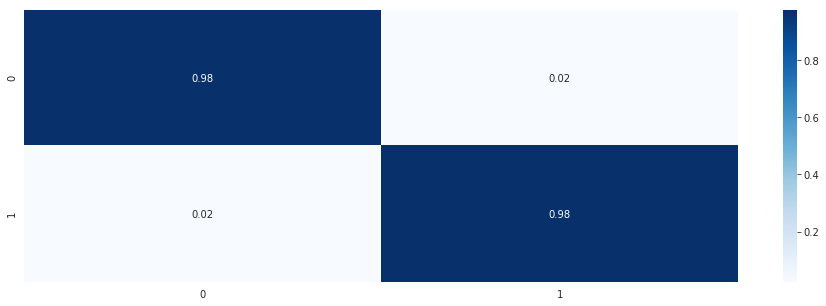

In [9]:
f = plt.subplots(1, 1, figsize=(16, 5), sharex=True)
train_cnf_matrix = confusion_matrix(train['target'], [np.round(x) for x in train['preds_avg']])
train_cnf_matrix_norm = train_cnf_matrix / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=[0, 1], columns=[0, 1])
sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

## Metrics ROC AUC

In [10]:
print('PCA VT Stdv         %.5f' % roc_auc_score(train['target'], train['preds_pca_vt_stdv']))
print('PCA VT              %.5f' % roc_auc_score(train['target'], train['preds_pca_vt']))
print('PCA                 %.5f' % roc_auc_score(train['target'], train['preds_pca']))
print('PCA Stdv            %.5f' % roc_auc_score(train['target'], train['preds_pca_stdv']))
print('Averaged not VT AUC %.5f' % roc_auc_score(train['target'], train['preds_avg_nvt']))
print('Averaged VT AUC     %.5f' % roc_auc_score(train['target'], train['preds_avg_vt']))
print('Averaged AUC        %.5f' % roc_auc_score(train['target'], train['preds_avg']))

PCA VT Stdv         0.99418
PCA VT              0.99418
PCA                 0.99418
PCA Stdv            0.99418
Averaged not VT AUC 0.99418
Averaged VT AUC     0.99418
Averaged AUC        0.99418


### Test set with all models predictions

In [11]:
test[['id', 'target_avg', 'target_avg_nvt', 'target_avg_vt', 'target_pca_stdv', 'target_pca', 'target_pca_vt', 'target_pca_vt_stdv']].head()

,id,target_avg,target_avg_nvt,target_avg_vt,target_pca_stdv,target_pca,target_pca_vt,target_pca_vt_stdv
0,1c13f2701648e0b0d46d8a2a5a131a53,0.999965,0.999965,0.999965,0.999965,0.999965,0.999965,0.999965
1,ba88c155ba898fc8b5099893036ef205,0.968717,0.968717,0.968717,0.968717,0.968717,0.968717,0.968717
2,7cbab5cea99169139e7e6d8ff74ebb77,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003
3,ca820ad57809f62eb7b4d13f5d4371a0,0.165305,0.165305,0.165305,0.165305,0.165305,0.165305,0.165305
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.347101,0.347101,0.347101,0.347101,0.347101,0.347101,0.347101


# Test predictions
Now you can output predictions for each individual model and the ensembled models as well.

#### Averaged models submission

In [12]:
submission = test[['id', 'target_avg']]
submission.columns = ['id', 'target']
submission.to_csv('submission_avg.csv', index=False)
submission.head()

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,0.999965
1,ba88c155ba898fc8b5099893036ef205,0.968717
2,7cbab5cea99169139e7e6d8ff74ebb77,0.000003
3,ca820ad57809f62eb7b4d13f5d4371a0,0.165305
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.347101


In [13]:
submission = test[['id', 'target_avg_nvt']]
submission.columns = ['id', 'target']
submission.to_csv('submission_avg_nvt.csv', index=False)
submission.head()

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,0.999965
1,ba88c155ba898fc8b5099893036ef205,0.968717
2,7cbab5cea99169139e7e6d8ff74ebb77,0.000003
3,ca820ad57809f62eb7b4d13f5d4371a0,0.165305
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.347101


In [14]:
submission = test[['id', 'target_avg_vt']]
submission.columns = ['id', 'target']
submission.to_csv('submission_avg_vt.csv', index=False)
submission.head()

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,0.999965
1,ba88c155ba898fc8b5099893036ef205,0.968717
2,7cbab5cea99169139e7e6d8ff74ebb77,0.000003
3,ca820ad57809f62eb7b4d13f5d4371a0,0.165305
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.347101


In [15]:
submission = test[['id', 'target_pca_stdv']]
submission.columns = ['id', 'target']
submission.to_csv('submission_pca_stdv.csv', index=False)
submission.head()

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,0.999965
1,ba88c155ba898fc8b5099893036ef205,0.968717
2,7cbab5cea99169139e7e6d8ff74ebb77,0.000003
3,ca820ad57809f62eb7b4d13f5d4371a0,0.165305
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.347101


In [16]:
submission = test[['id', 'target_pca']]
submission.columns = ['id', 'target']
submission.to_csv('submission_pca.csv', index=False)
submission.head()

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,0.999965
1,ba88c155ba898fc8b5099893036ef205,0.968717
2,7cbab5cea99169139e7e6d8ff74ebb77,0.000003
3,ca820ad57809f62eb7b4d13f5d4371a0,0.165305
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.347101


In [17]:
submission = test[['id', 'target_pca_vt']]
submission.columns = ['id', 'target']
submission.to_csv('submission_pca_vt.csv', index=False)
submission.head()

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,0.999965
1,ba88c155ba898fc8b5099893036ef205,0.968717
2,7cbab5cea99169139e7e6d8ff74ebb77,0.000003
3,ca820ad57809f62eb7b4d13f5d4371a0,0.165305
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.347101


In [18]:
submission = test[['id', 'target_pca_vt_stdv']]
submission.columns = ['id', 'target']
submission.to_csv('submission_pca_vt_stdv.csv', index=False)
submission.head()

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,0.999965
1,ba88c155ba898fc8b5099893036ef205,0.968717
2,7cbab5cea99169139e7e6d8ff74ebb77,0.000003
3,ca820ad57809f62eb7b4d13f5d4371a0,0.165305
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.347101
